# Deconvolution Visualization

## Where the data at?

In [1]:
input_path = '../Data/Processed_Data/'
output_path = '../Data/Processed_Data/Cell_Deconvolution/'

## Load Data

We will start by loading the mC ARIC deconvolution data.

In [2]:
import pandas as pd

# Read deconvolution results
deconv = pd.read_csv(output_path+'Results_TrainData_ARIC.csv', index_col=0)
deconv_test = pd.read_csv(output_path+'Results_TestData_ARIC.csv', index_col=0)

In [6]:
# Import Plotting Functions
from FM_Functions.Data_Visualization import *
sns.set_theme(style="white")

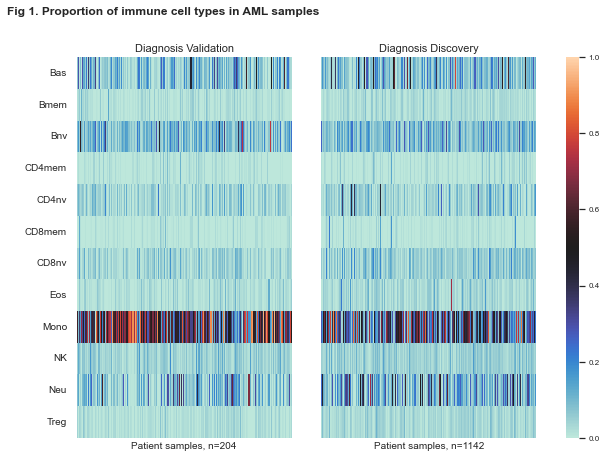

In [7]:
deconv.index.name = None
deconv_test.index.name = None
draw_heatmaps(fig_title = 'Proportion of immune cell types in AML samples',
            t1='Diagnosis Validation', t2= 'Diagnosis Discovery',
            df1 = deconv_test, df2 = deconv,
            save_plot=True, fig_number=1, figsize=(9,7))

## Import CIBERSORTx Results

In [21]:
df_ = pd.read_csv(output_path+'COG_clinicaldata_ciberscore_FMcleaned.csv')
df_test = pd.read_csv(output_path+'AML02_clinicaldata_ciberscore_FMcleaned.csv',index_col=0).iloc[:,:22]

# break 'Mixture' column by '-' and add to df
df_['Patient_ID'] = df_['Mixture'].str.split('-', expand=True)[2]

# Set index to Patient ID
df_ = df_.set_index('Patient_ID')

# Remove induction failure patients
df = df_[df_['Tumor Code'] == '20 - Acute myeloid leukemia (AML)']

# Select columns of interest
cibersortx = df.iloc[:,1:23].join(df[['LSC6','pLSC6_gb']])

y = pd.read_csv(input_path+'y.csv', index_col=0)

# Split data into training and test sets by clinical trial
y_train = y[~y['Clinical Trial'].isin(['AML02','AML08'])]
y_test = y[y['Clinical Trial'].isin(['AML02'])].reset_index().set_index('U133A.Dx.ID')

# Harmonize index of deconvolution results to match cibersortx
y_train2 = y_train.drop(columns=['pLSC6_gb']).join(cibersortx, how='inner', on='Patient_ID')
y_test2 = y_test.join(df_test, how='inner').set_index('index')

# Select columns containing cibersortx results
mRNA_deconv = y_train2.iloc[:,-24:-2]
mRNA_deconv_test = y_test2.iloc[:,-22:]

# Adjust index of deconvolution results to match y_train3
mC_deconv = deconv.T.loc[mRNA_deconv.index]
mC_deconv_test = deconv_test.T.loc[y_test2.index]

# Remove index name
mC_deconv_test.index.name = None

# # Standardize dataset (z-scoring)
# def standardize(df):
#     return (df-df.mean())/df.std()

# Normalize dataset (min-max scaling)
# def normalize(df):
#     return (df-df.min())/(df.max()-df.min())

# mC_deconv = normalize(mC_deconv)
# mC_deconv_test = normalize(mC_deconv_test)

# Concat mC_deconv and mRNA deconv
mC_mRNA_deconv = pd.concat([mC_deconv, mRNA_deconv], axis=1, join='inner')
mC_mRNA_deconv_test = pd.concat([mC_deconv_test, mRNA_deconv_test], axis=1)


In [6]:
# y3 = y2.join(df[['LSC6','pLSC6_gb']], how='left', on='Patient_ID', rsuffix='_')

In [7]:
# # Concat deconv and deconv_test
# mC_deconv = pd.concat([deconv.T, deconv_test.T], axis=0)

# # Merge mC_deconv with y
# y2 = y.join(mC_deconv, how='inner')

# # Merge y2 with LSC6 info 

# y3 = y2.join(df[['LSC6','pLSC6_gb']], how='left', on='Patient_ID', rsuffix='_')

# # Save y2
# y3.to_csv(output_path+'y_plus_cibersortx_ARICresults.csv')

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def compute_correlation(df1, df2):
    """
    Computes the correlation between columns of two dataframes.
    Returns a dataframe with the correlation values.

    Parameters:
        df1 (pandas.DataFrame): First dataframe.
        df2 (pandas.DataFrame): Second dataframe.

    Returns:
        pandas.DataFrame: Dataframe with correlation values.
    """
    
    # Compute the number of columns in each dataframe
    n1, n2 = len(df1.columns), len(df2.columns)

    # Initialize an empty dataframe to store correlation values
    corr_df = pd.DataFrame(index=df1.columns, columns=df2.columns)

    # Loop over the columns of each dataframe
    for i in tqdm(range(n1)):
        col1 = df1.iloc[:, i]
        for j in range(n2):
            col2 = df2.iloc[:, j]

            # Compute the correlation between the two columns
            corr = np.corrcoef(col1, col2)[0, 1]

            # Store the correlation value in the appropriate position in the output dataframe
            corr_df.iloc[i, j] = corr

    return corr_df

df_corr = compute_correlation(mC_deconv, mRNA_deconv)
df_corr_test = compute_correlation(mC_deconv_test, mRNA_deconv_test)

100%|██████████| 12/12 [00:00<00:00, 304.30it/s]


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_matrix(df_corr, num_samples, fig_title, save_plot=False):
    """
    Plots a correlation matrix.

    Parameters:
    ------------
        df_corr (pandas.DataFrame):Dataframe containing correlation values.
        num_samples (int): Number of samples used to compute the correlation matrix.
        cohort (str): Name of the cohort used to compute the correlation matrix.

    Returns:
    ------------
        None
    
    """

    sns.set_theme(style="white")
    
    # Compute the correlation matrix
    corr = df_corr.astype(float)
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 16))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0, annot=True,
                square=True, linewidths=1, cbar_kws={"shrink": .4},
                annot_kws={"fontsize":8}, fmt='.2f')
    
    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)
    
    # Adjust xticks text
    plt.xticks(rotation=45, ha='right', fontsize='medium')
    
    # Set plot specs
    plt.title(fig_title + f' in, n={num_samples}',
              fontsize='medium', y=1, fontweight='bold', pad=15)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add axis labels
    plt.ylabel('mC Deconvolution', fontsize='medium', fontweight='bold')
    plt.xlabel('mRNA Deconvolution', fontsize='medium', fontweight='bold')

    if save_plot == True:
        plt.savefig('../Figures/Heatmaps/' + fig_title,
                    bbox_inches='tight', dpi=300)
    

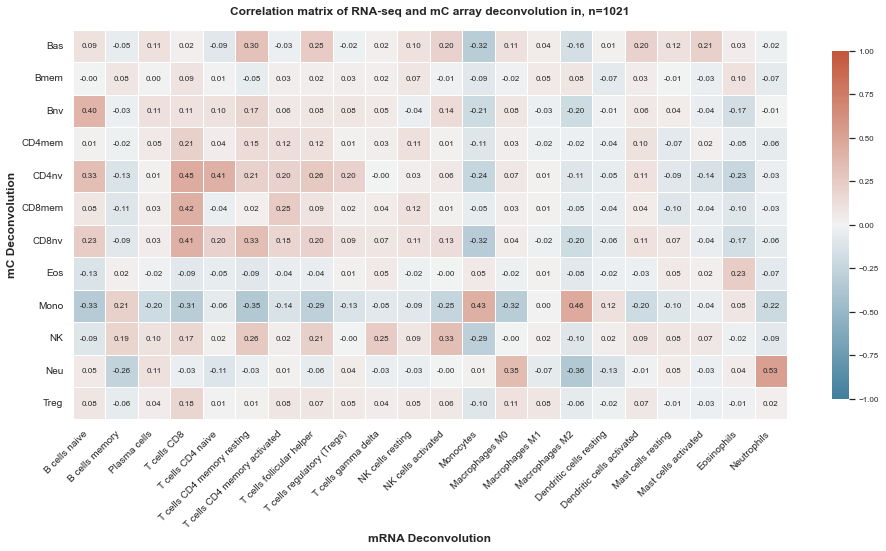

In [10]:
plot_correlation_matrix(df_corr, num_samples=len(mRNA_deconv),
                        fig_title='Correlation matrix of RNA-seq and mC array deconvolution',
                        save_plot=True)

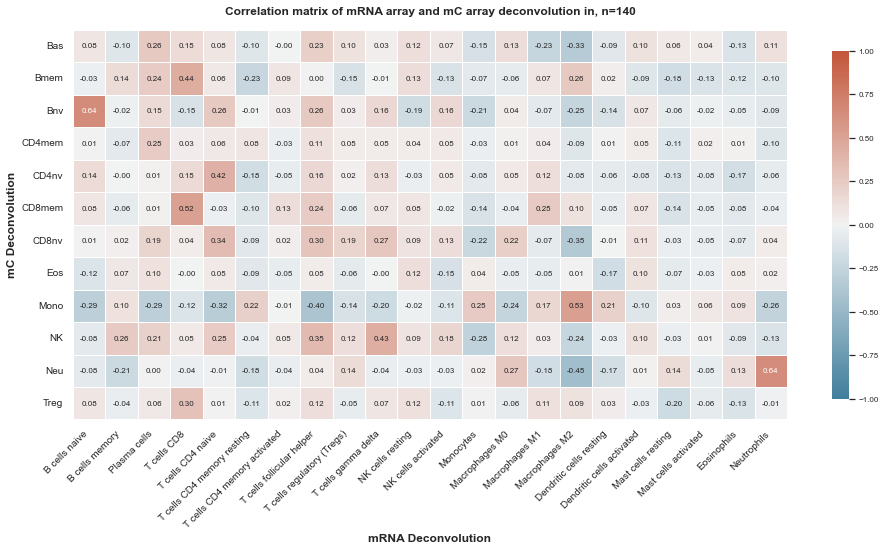

In [11]:
plot_correlation_matrix(df_corr_test, num_samples=len(mRNA_deconv_test),
                        fig_title='Correlation matrix of mRNA array and mC array deconvolution',
                        save_plot=True)

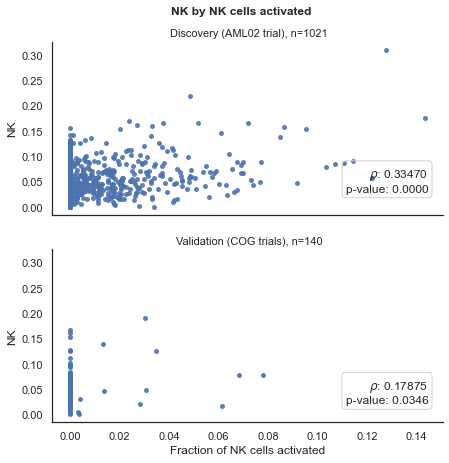

In [12]:
draw_scatterplot(df_train=mC_mRNA_deconv,df_test=mC_mRNA_deconv_test,
                x='NK cells activated',y='NK',
                hue=None, s=25, save_plot=False)


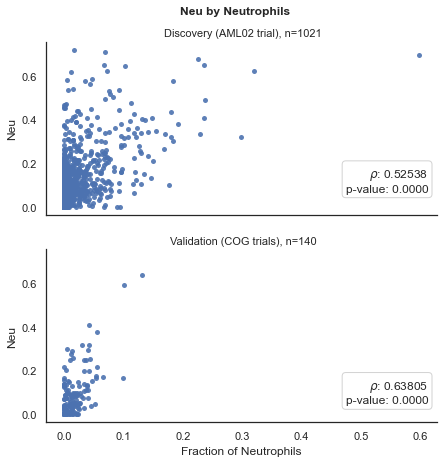

In [13]:
draw_scatterplot(df_train=mC_mRNA_deconv,df_test=mC_mRNA_deconv_test,
                x='Neutrophils',y='Neu',
                hue=None, s=25, save_plot=False)

## Patient Characteristics Table

In [19]:
from tableone import TableOne

In [35]:
df_all = pd.concat([df_,y_train2.set_index('Patient_ID')],
                   join='outer',keys=['All Samples','Overlapping Samples']).reset_index(
                   level=0, names='cohort').reset_index()

In [36]:
columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Vital Status', 'Leucocyte counts (10⁹/L)',
            'Risk Group','FLT3 ITD']

In [41]:
mytable_all = TableOne(df_all, columns,overall=False,missing=True,pval=True,htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,
                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                        groupby='cohort')
mytable_all.tabulate(tablefmt="html", headers=['Checking for bias in overlapping samples',"",
                                               'Missing','All Samples','Overlapping Samples',
                                               'p-value','Statistical Test'])

Checking for bias in overlapping samples,,Missing,All Samples,Overlapping Samples,p-value,Statistical Test
n,,,1696,1021,,
"Age (years), mean (SD)",,0,9.7 (6.4),9.4 (6.4),0.288,Two Sample T-test
"Age group (years), n (%)",≥10,0,850 (50.1),501 (49.1),0.624,Chi-squared
,<10,,846 (49.9),520 (50.9),,
"Sex, n (%)",Female,0,815 (48.1),514 (50.3),0.264,Chi-squared
,Male,,881 (51.9),507 (49.7),,
"Race or ethnic group, n (%)",White,237,1237 (80.7),753 (79.5),<0.001,Chi-squared
,Black or African American,,195 (12.7),110 (11.6),,
,Asian,,74 (4.8),45 (4.8),,
,American Indian or Alaska Native,,10 (0.7),5 (0.5),,
